# 1. Import libraries

In [1]:
# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# From here, add any libraries that you might need for the rest of your code
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, Nadam

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Set the paths based on your Drive directory
data_dir ='/kaggle/input/brain-tumor-mri-dataset' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: /kaggle/input/brain-tumor-mri-dataset
Training directory: /kaggle/input/brain-tumor-mri-dataset/Training
Testing directory: /kaggle/input/brain-tumor-mri-dataset/Testing


In [4]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# Load and preprocess the data
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale'
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# 3. Visualise data and plot data distribution

In [5]:
# Randomly select 15 samples from the dataset, for each selected sample, display image along with its corresponding label
num_samples = 15
np.random.seed(99) #to ensure the data retrieved will be the same
indices = np.random.choice(len(train_data), num_samples, replace=False)

#create list to store random images and labels
random_images = []
random_labels = []

#label names
labels = list(train_data.class_indices.keys())
#iterate trough the index
for idx in indices:
    train_data.reset()
    batch, labels = next(train_data)
    image = batch[idx % train_data.batch_size]
    label = labels[idx % train_data.batch_size]
    random_images.append(image)
    random_labels.append(label)

random_images = np.array(random_images) #convert into np.array
random_labels = np.array(random_labels)

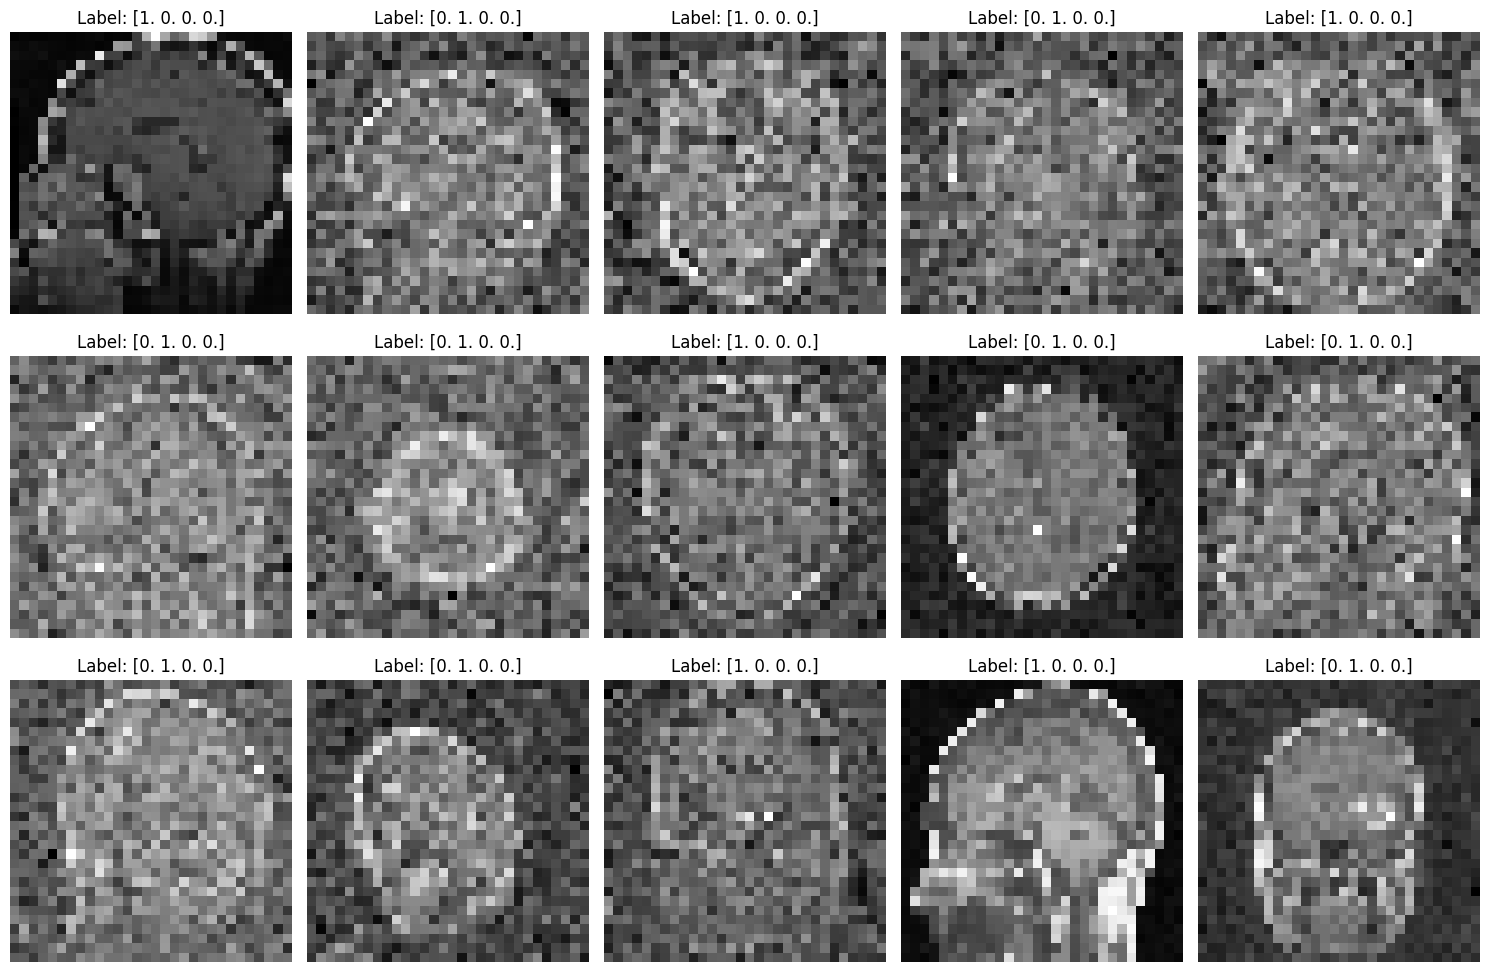

In [6]:
# Visualise data
plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(random_images[i].squeeze(), cmap='gray')
    label_index = np.argmax(random_labels[i])
    label_name = labels[label_index]
    plt.title(f"Label: {label_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()

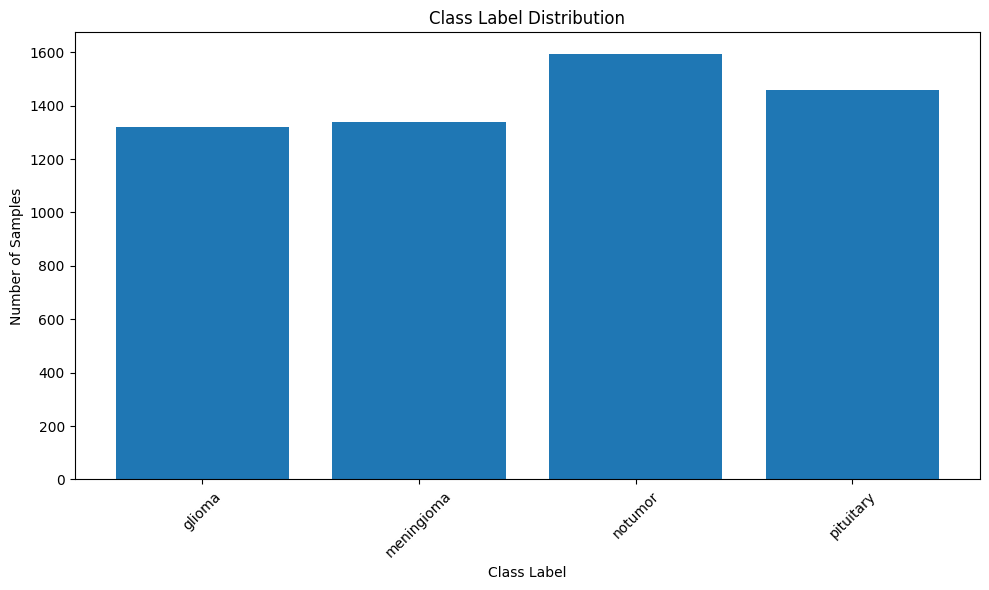

In [7]:
# Create a bar plot to visualize the class label distribution of the train-dataset
class_index_train = train_data.class_indices
#get train samples
train_samples = train_data.samples
#get the distribution
class_counts_train = np.bincount(train_data.classes)

#create a dictionary to store the distribution

class_distribution = {class_name : count for class_name, count in zip(class_index_train.keys(), class_counts_train)}


#create barplot
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Class Label Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

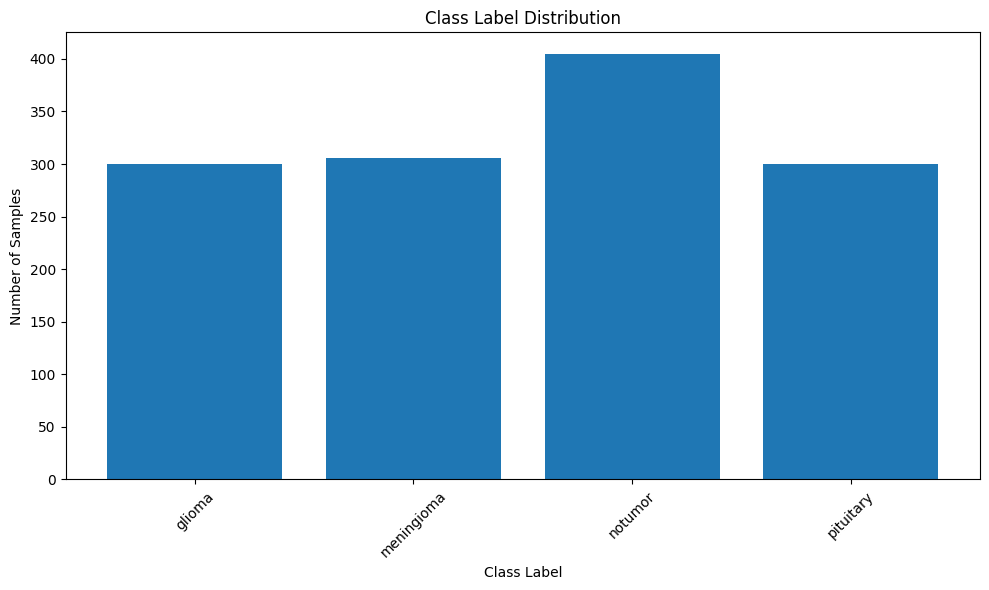

In [8]:
# Create a bar plot to visualize the class label distribution of the test-dataset
class_index_test = test_data.class_indices
#get train samples
test_samples = train_data.samples
#get the distribution
class_counts_test = np.bincount(test_data.classes)

#create a dictionary to store the distribution

class_distribution = {class_name : count for class_name, count in zip(class_index_test.keys(), class_counts_test)}


#create barplot
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Class Label Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Train and Evaluation functions

In [9]:
#split the images and labels for X and Y variables

X = []
y = []

for i in range(len(train_data)) :
    images,labels = next(train_data)
    X.extend(images)
    y.extend(labels)

#Turn the data into array
X = np.array(X)
y = np.array(y)

In [10]:
#Split the data into training and validation set

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 50)

#Confirm the data has been split

print(f"Number of values of X_Train: {X_train.shape}")
print(f"Number of values of y_train: {y_train.shape}")
print(f"Number of values of X_val: {X_val.shape}")
print(f"Number of values of y_val: {y_val.shape}")

Number of values of X_Train: (4569, 30, 30, 1)
Number of values of y_train: (4569, 4)
Number of values of X_val: (1143, 30, 30, 1)
Number of values of y_val: (1143, 4)


In [11]:
#Baseline model

#Create a sequential model
model = Sequential()

#add convolutional and pooling layers

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape = (30,30,1))) #Convulutional layer with 32 filters and size of 3 x 3, activation is Relu
model.add(layers.MaxPooling2D((2, 2))) #Followed by max pooling layer size 2x2
model.add(layers.Conv2D(32, (3, 3), activation='relu')) #Convolutional layer with 32 filters and 3,3. Activation = relu
model.add(layers.MaxPooling2D((2, 2))) #Followed by max pooling layer size 2x2
model.add(layers.Flatten())# flatten the first two layers to 1D vector
model.add(layers.Dense(32, activation = 'relu')) #finally dense layers of sizes 32 with relu activation function
model.add(layers.Dense(4, activation = 'softmax')) #output layer with softmax activation function -> the most proper for multiclass classification

#Compile the model
model.compile(optimizer = Adam(),#need to use Adam as the optimizer
             loss = 'categorical_crossentropy', #loss function should use this for multi-class classification
             metrics = ['accuracy']) #metrics should be accuracy

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
#check the model summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,596 (182.02 KB)

 Trainable params: 46,596 (182.02 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Model training - Baseline

In [13]:
#Train the model, set epcohs to 10 and batch size 32

history = model.fit(X_train,y_train,
                       epochs = 10,
                       batch_size = 32,
                       validation_data = (X_val,y_val))

Epoch 1/10


I0000 00:00:1727617280.539248    3952 service.cc:145] XLA service 0x7be0cc004230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727617280.539306    3952 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727617280.539310    3952 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 87/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2866 - loss: 1.3609

I0000 00:00:1727617281.945501    3952 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3287 - loss: 1.3115 - val_accuracy: 0.6247 - val_loss: 0.9211
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6610 - loss: 0.8750 - val_accuracy: 0.7034 - val_loss: 0.7733
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7108 - loss: 0.7574 - val_accuracy: 0.7297 - val_loss: 0.7075
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7497 - loss: 0.6578 - val_accuracy: 0.7297 - val_loss: 0.6745
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7605 - loss: 0.6143 - val_accuracy: 0.7612 - val_loss: 0.6036
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7845 - loss: 0.5853 - val_accuracy: 0.7813 - val_loss: 0.5878
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7846 - loss: 0.5550 - val_accuracy: 0.7655 - val_loss: 0.5881
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7903 - loss: 0.5412 - val_accuracy: 0.7883 - val

# 6. Model evaluation - Baseline

In [14]:
#Check the accuracy and loss
val_loss,val_acc = model.evaluate(X_val,y_val)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8048 - loss: 0.5293 


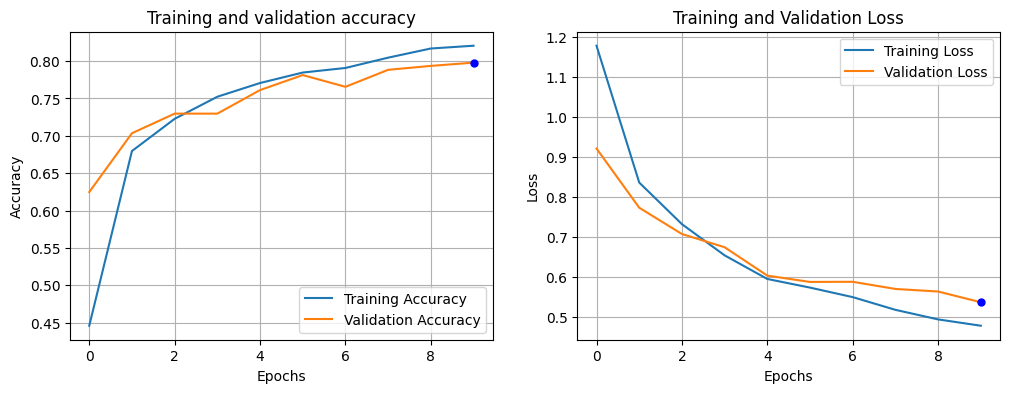

In [15]:
#Plot the training and validation loss and accuracy

plt.figure(figsize = (12,4))

#Plot training and validation accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#highlight best acc epoch

best_acc_epoch = np.argmax(history.history['val_accuracy'])

plt.plot(best_acc_epoch, history.history['val_accuracy'][best_acc_epoch],'bo', markersize = 5)
plt.grid()
#Plot training and validation loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#highlight best loss epoch

best_loss_epoch = np.argmin(history.history['val_loss'])
plt.plot(best_loss_epoch, history.history['val_loss'][best_loss_epoch],'bo', markersize = 5)

#show the plot
plt.grid()
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


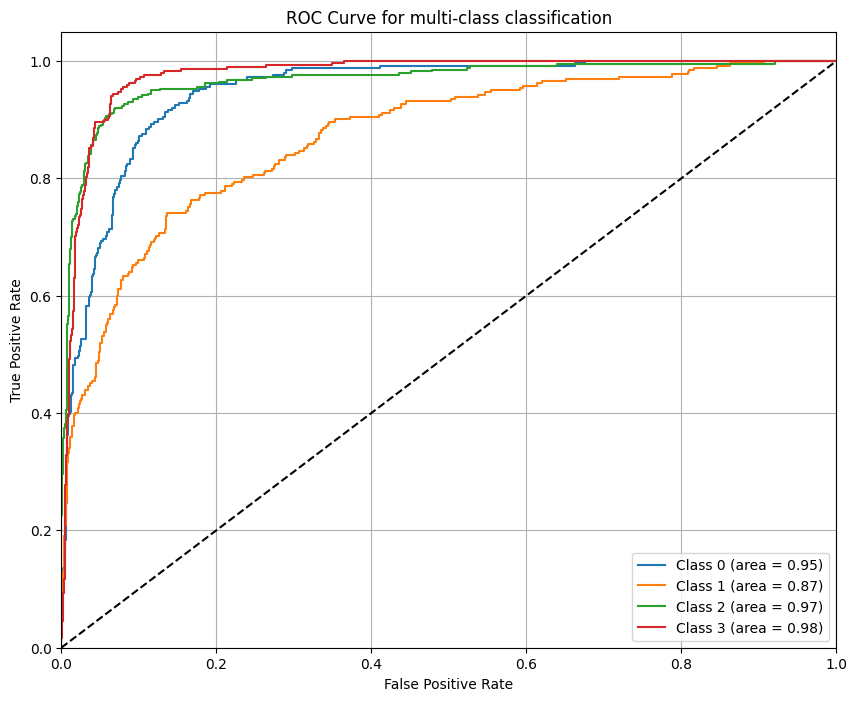

In [16]:
#Plot ROC Curve

from sklearn.metrics import roc_curve, auc

def roc(y, y_pred, n_class):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_class):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
    plt.figure(figsize=(10, 8))
    for i in range(n_class):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for multi-class classification')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


y_pred = model.predict(X_val) #get the probabilities of validation data

n_class = y_val.shape[1]

roc(y_val,y_pred,n_class)

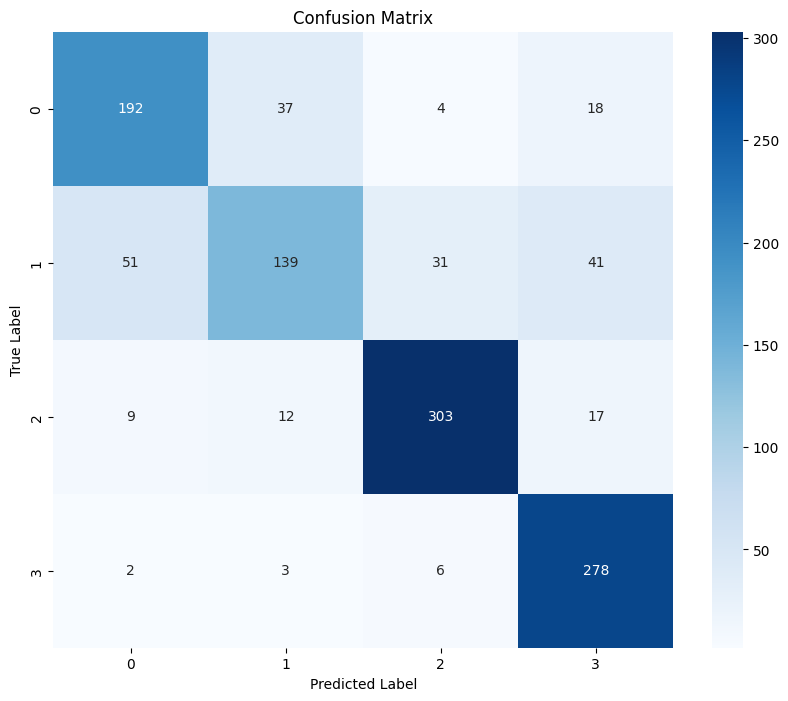

In [17]:
#Plot confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

def cm(y,y_pred):
    cm = confusion_matrix(y.argmax(axis=1), y_pred.argmax(axis=1)) #use the previous probabilities

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

cm(y_val,y_pred)

### Predict the test data

In [18]:
#split the images and labels for X and Y variables

X_test = []
y_test = []

for i in range(len(test_data)) :
    images,labels = next(test_data)
    X_test.extend(images)
    y_test.extend(labels)

#Turn the data into array
X_test = np.array(X_test)
y_test = np.array(y_test)

In [19]:
#Check if X_test and y_test has the correct shape and the correct values

print(f"Number of values of X_test: {X_test.shape}")
print(f"Number of vlaues of y_test:{y_test.shape}")

Number of values of X_test: (1311, 30, 30, 1)
Number of vlaues of y_test:(1311, 4)


In [20]:
y_test_pred = model.predict(X_test)

#Do evaluation
test_loss, test_acc = model.evaluate(X_test,y_test)
#Print the result
print(f"Test ACC: {test_acc}, Test LOSS: {test_loss}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6923 - loss: 0.7997
Test ACC: 0.7589626312255859, Test LOSS: 0.6441059708595276


### ROC Plot - Test Data

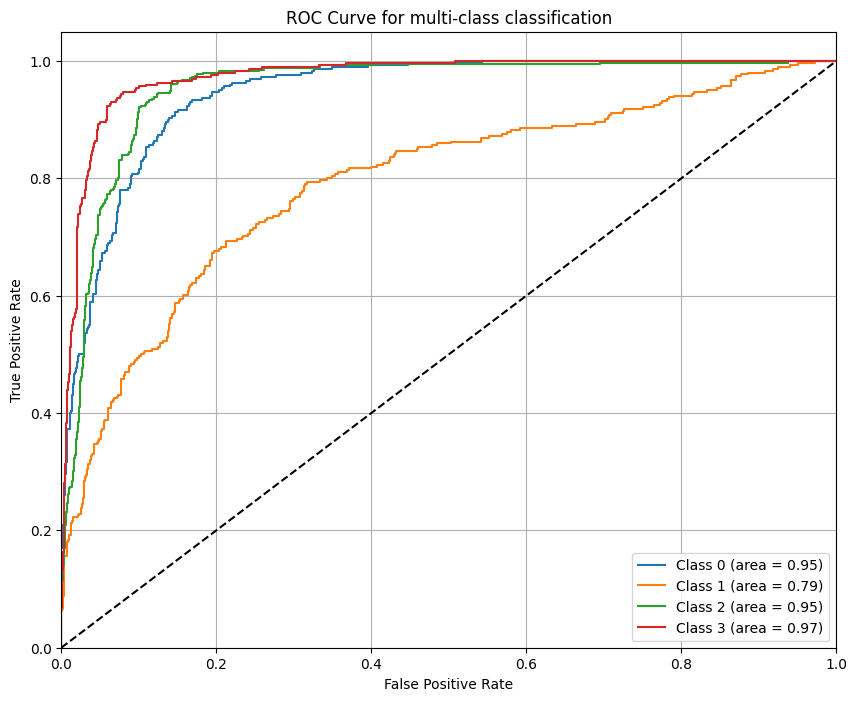

In [21]:
roc(y_test,y_test_pred,n_class)

### Confusion Matrix Plot - Test Data

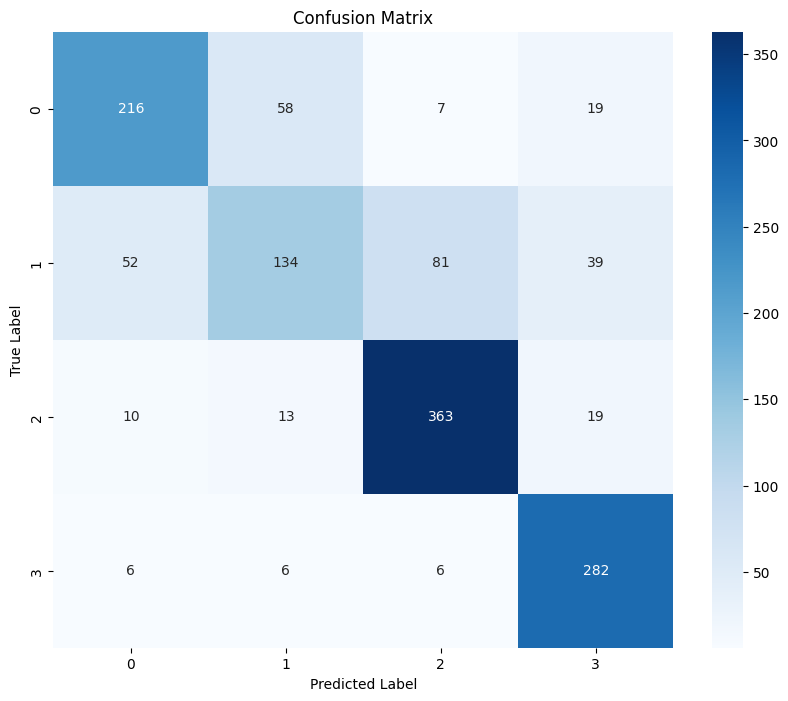

In [22]:
cm(y_test,y_test_pred)

# Report Performance Measures - Baseline Model

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_class = np.argmax(y_test_pred,axis = 1) #using the result of test prediction data
y_test_class = np.argmax(y_test, axis =1) #based on y_test data
yval_pred_class = np.argmax(y_pred,axis = 1) #y_pred is the variable name when predicting validation set
yval_class = np.argmax(y_val,axis = 1)

#Metrics calculation
val_precision = precision_score(yval_class,yval_pred_class, average = 'weighted')
val_recall = recall_score(yval_class, yval_pred_class, average = 'weighted')
val_f1 = f1_score(yval_class, yval_pred_class, average = 'weighted')
test_precision = precision_score(y_test_class,y_pred_class, average = 'weighted')
test_recall = recall_score(y_test_class, y_pred_class, average = 'weighted')
test_f1 = f1_score(y_test_class, y_pred_class, average = 'weighted')

print("VALIDATION DATA METRICS")
print()
print(f"Val Acc: {val_acc}") #We already calculate it while calculating loss function as well
print(f"Val Precision: {val_precision}")
print(f"Val Recall: {val_recall}")
print(f"Val F1: {val_f1}")
print()

print("TEST DATA METRICS")
print()
print(f"Test Acc: {test_acc}") #We already calculate it while calculating loss function as well
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1: {test_f1}")

VALIDATION DATA METRICS

Val Acc: 0.7979002594947815
Val Precision: 0.7941511819178055
Val Recall: 0.7979002624671916
Val F1: 0.7902148965433798

TEST DATA METRICS

Test Acc: 0.7589626312255859
Test Precision: 0.7474074799313912
Test Recall: 0.7589626239511823
Test F1: 0.746297006795921


### Enhanced Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model2 = Sequential()

# First Convolutional Block

model2.add(layers.Conv2D(32, (3, 3), padding='same', activation='linear', input_shape=(30, 30, 1)))
model2.add(layers.Dropout(0.1))
model2.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))

# Second Convolutional Block
model2.add(layers.Conv2D(64, (3, 3), padding='same', activation='linear'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))

# Third Convolutional Block
model2.add(layers.Conv2D(128, (3, 3), padding='same', activation='linear'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))

# Global Average Pooling instead of Flatten
model2.add(layers.Flatten())

# Fully Connected Layers
model2.add(layers.Dense(64, activation='relu'))

# Output Layer
model2.add(layers.Dense(4, activation='softmax'))  # Keeping softmax for multiclass output

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0005)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,380 (1.38 MB)

 Trainable params: 360,932 (1.38 MB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
#Train the model, set epcohs to 50 and batch size 64

history2 = model2.fit(X_train,y_train,
                       epochs = 50,
                       batch_size = 64,
                       validation_data = (X_val,y_val))

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.5297 - loss: 1.2789 - val_accuracy: 0.2292 - val_loss: 1.3820
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7300 - loss: 0.6933 - val_accuracy: 0.2292 - val_loss: 1.6175
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7643 - loss: 0.5955 - val_accuracy: 0.2318 - val_loss: 1.8056
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8097 - loss: 0.4837 - val_accuracy: 0.3237 - val_loss: 1.4219
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8343 - loss: 0.4181 - val_accuracy: 0.5022 - val_loss: 1.2942
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8576 - loss: 0.3767 - val_accuracy: 0.7165 - val_loss: 0.7100
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8739 - loss: 0.3220 - val_accuracy: 0.7472 - val_loss: 0.6556
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8969 - loss: 0.2832 - val_accuracy: 0.8014 - val_lo

In [27]:
#Check the accuracy and loss
val_loss2,val_acc2 = model2.evaluate(X_val,y_val)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8654 - loss: 0.6662


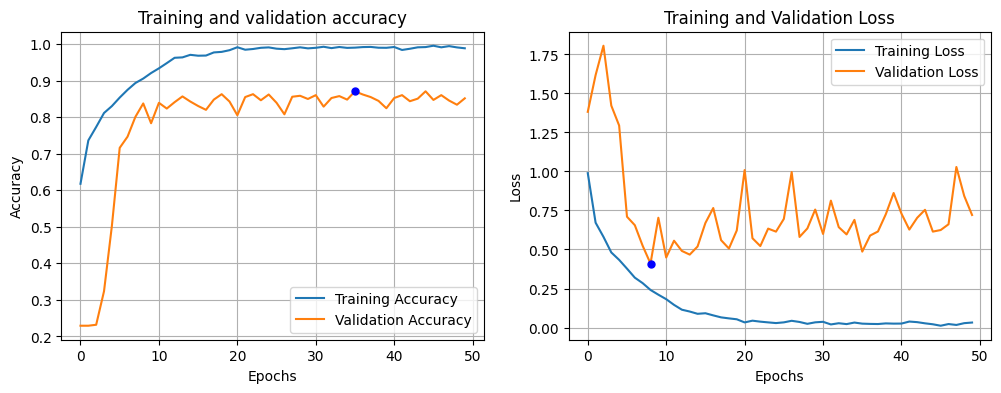

In [28]:
#Plot the training and validation loss and accuracy

plt.figure(figsize = (12,4))

#Plot training and validation accuracy
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label = 'Training Accuracy')
plt.plot(history2.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#highlight best acc epoch

best_acc_epoch = np.argmax(history2.history['val_accuracy'])

plt.plot(best_acc_epoch, history2.history['val_accuracy'][best_acc_epoch],'bo', markersize = 5)
plt.grid()
#Plot training and validation loss

plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label = 'Training Loss')
plt.plot(history2.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#highlight best loss epoch

best_loss_epoch = np.argmin(history2.history['val_loss'])
plt.plot(best_loss_epoch, history2.history['val_loss'][best_loss_epoch],'bo', markersize = 5)

#show the plot
plt.grid()
plt.show()

### ROC Plot - Enhanced Model

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


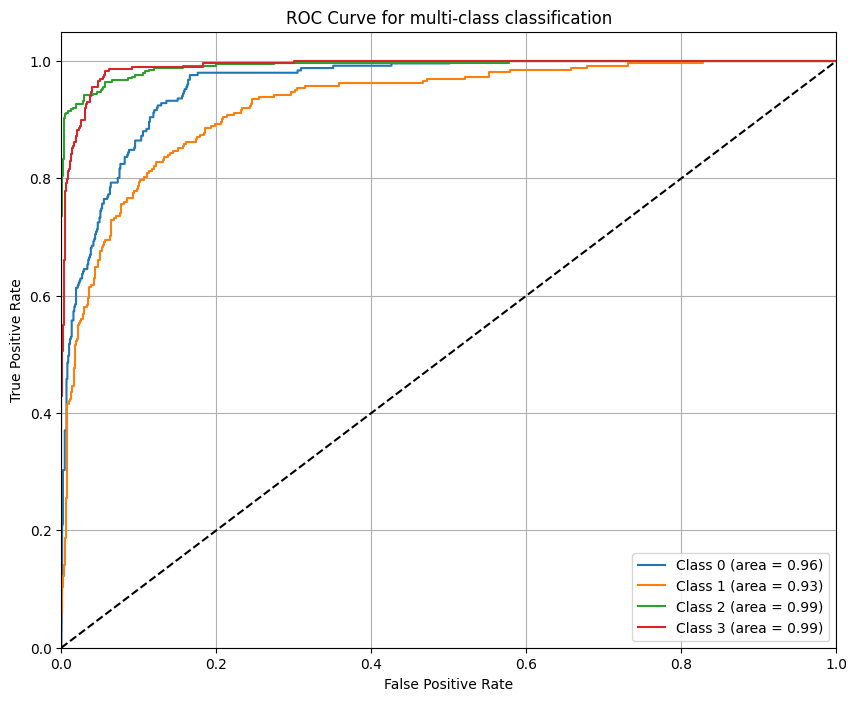

In [29]:
#ROC Plot
y_pred2 = model2.predict(X_val) #get the probabilities of validation data

n_class = y_val.shape[1]

roc(y_val,y_pred2,n_class)

In [30]:
#Predict test data
y_test_pred2 = model2.predict(X_test)

#Do evaluation
test_loss2, test_acc2 = model2.evaluate(X_test,y_test)
#Print the result
print(f"Test ACC: {test_acc2}, Test LOSS: {test_loss2}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8526 - loss: 0.6362
Test ACC: 0.8619374632835388, Test LOSS: 0.6214045286178589


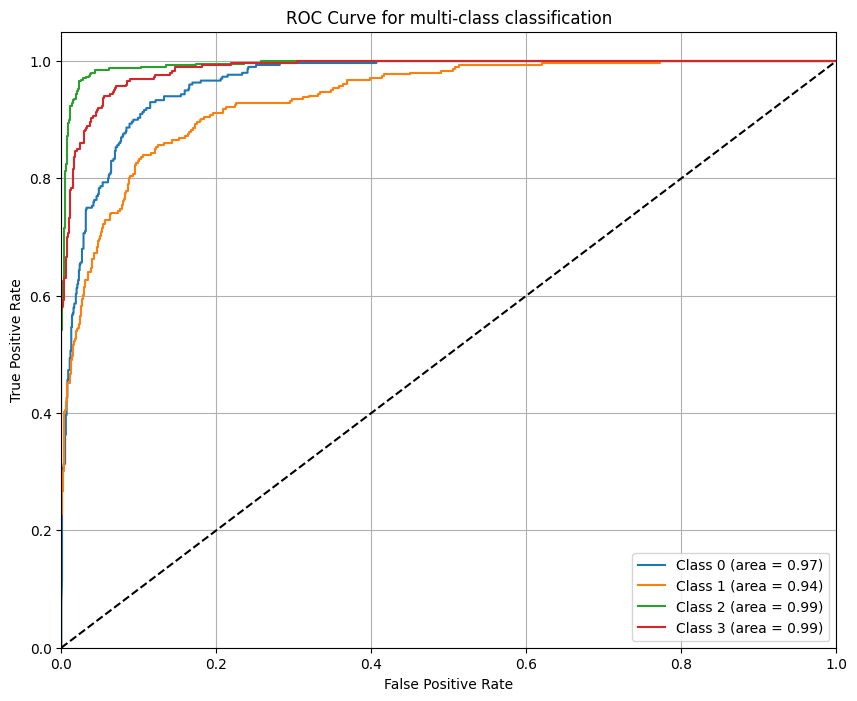

In [31]:
#ROC Plot
roc(y_test,y_test_pred2,n_class)

### Confusion Matrix - Enhanced Model

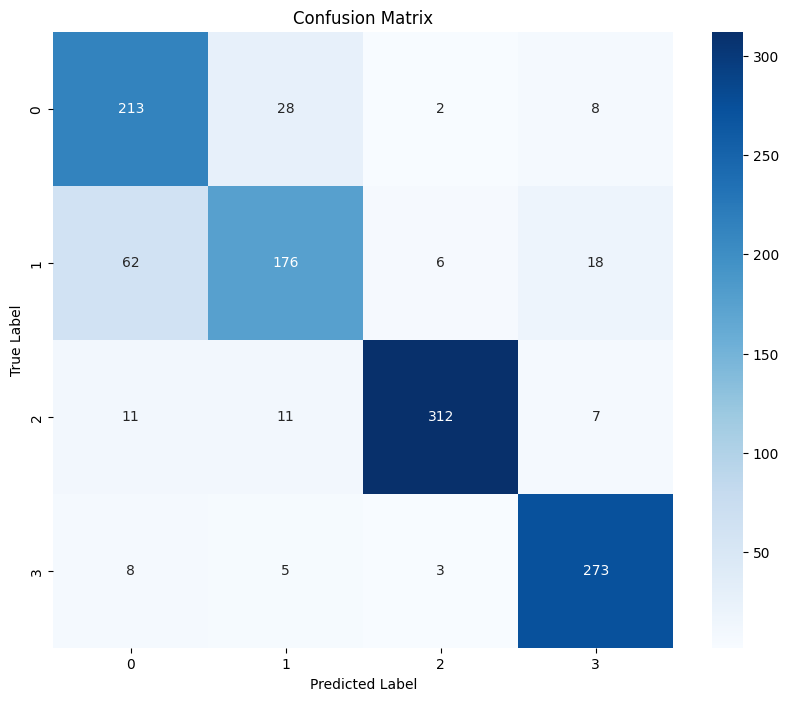

In [32]:
#Confusion Matrix
cm(y_val,y_pred2)

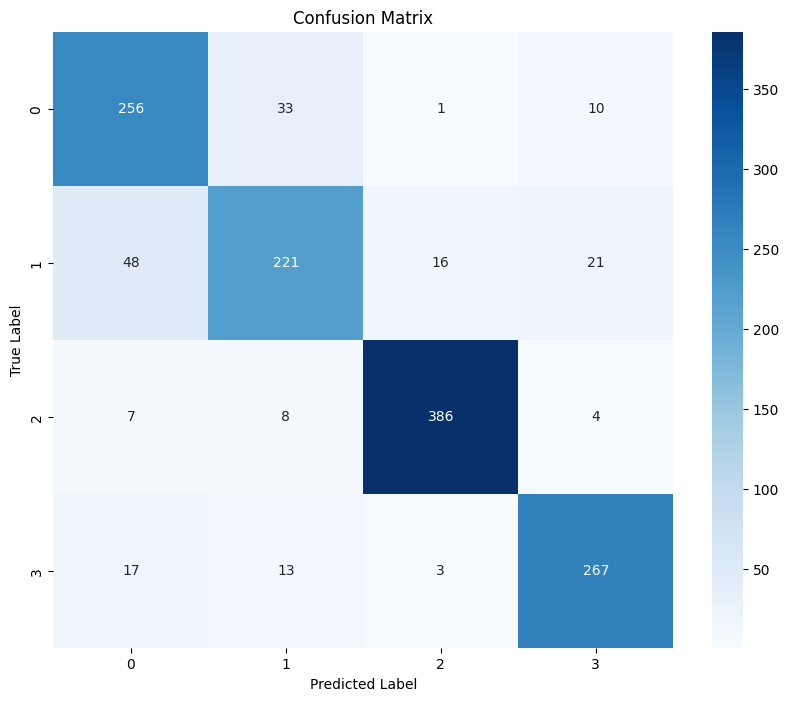

In [33]:
#Confusion Matrix
cm(y_test,y_test_pred2)

In [34]:
y_pred_class2 = np.argmax(y_test_pred2,axis = 1) #using the result of test prediction data
y_test_class2 = np.argmax(y_test, axis =1) #based on y_test data
yval_pred_class2 = np.argmax(y_pred2,axis = 1) #y_pred is the variable name when predicting validation set
yval_class2 = np.argmax(y_val,axis = 1)

#Metrics calculation
val_precision2 = precision_score(yval_class2,yval_pred_class2, average = 'weighted')
val_recall2 = recall_score(yval_class2, yval_pred_class2, average = 'weighted')
val_f12 = f1_score(yval_class2, yval_pred_class2, average = 'weighted')
test_precision2 = precision_score(y_test_class2,y_pred_class2, average = 'weighted')
test_recall2 = recall_score(y_test_class2, y_pred_class2, average = 'weighted')
test_f12 = f1_score(y_test_class2, y_pred_class2, average = 'weighted')

print("VALIDATION DATA METRICS")
print()
print(f"Val Acc: {val_acc2}") #We already calculate it while calculating loss function as well
print(f"Val Precision: {val_precision2}")
print(f"Val Recall: {val_recall2}")
print(f"Val F1: {val_f12}")
print()

print("TEST DATA METRICS")
print()
print(f"Test Acc: {test_acc2}") #We already calculate it while calculating loss function as well
print(f"Test Precision: {test_precision2}")
print(f"Test Recall: {test_recall2}")
print(f"Test F1: {test_f12}")

VALIDATION DATA METRICS

Val Acc: 0.8521434664726257
Val Precision: 0.8562268320322558
Val Recall: 0.8521434820647419
Val F1: 0.851433443852325

TEST DATA METRICS

Test Acc: 0.8619374632835388
Test Precision: 0.8621968862695315
Test Recall: 0.8619374523264683
Test F1: 0.8611859091102365


### Conducting Transfer Learning

In [35]:
import cv2

In [49]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D, LeakyReLU

def prepare_image(image, target_size=(96, 96)):
    
    #Convert channel from grayscale to RGB
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Resize the image using OpenCV
    image = cv2.resize(image, target_size)
    
    # Preprocess the image for VGG16
    image = preprocess_input(image)
    
    return image

# Prepare the entire dataset
X_train_transfer = np.array([prepare_image(img) for img in X_train])
X_val_transfer = np.array([prepare_image(img) for img in X_val])
X_test_transfer = np.array([prepare_image(img) for img in X_test])


#check if the data has been transformed

print(X_train_transfer.shape)
print(X_val_transfer.shape)
print(X_test_transfer.shape)

(4569, 96, 96, 3)
(1143, 96, 96, 3)
(1311, 96, 96, 3)


In [55]:
from tensorflow.keras.models import Model
#Construct base model
transfer_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

#Freeze Layers
transfer_base_model.trainable = False

x = transfer_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

transfer_model = Model(inputs=transfer_base_model.input, outputs=outputs)

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [56]:
history_transfer = transfer_model.fit(X_train_transfer, y_train, 
                                      validation_data=(X_val_transfer, y_val),
                                      epochs=50, batch_size=64)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.2499 - loss: 2.8402 - val_accuracy: 0.2957 - val_loss: 1.3801
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.2737 - loss: 1.3974 - val_accuracy: 0.2983 - val_loss: 1.3792
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.2910 - loss: 1.3789 - val_accuracy: 0.2607 - val_loss: 1.3824
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.2798 - loss: 1.3788 - val_accuracy: 0.2852 - val_loss: 1.3737
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.2867 - loss: 1.3798 - val_accuracy: 0.2931 - val_loss: 1.3757
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.2888 - loss: 1.3785 - val_accuracy: 0.3036 - val_loss: 1.3755
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.2739 - loss: 1.3778 - val_accuracy: 0.3237 - val_loss: 1.3711
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.2909 - loss: 1.3754 - val_accuracy: 0.3325 - 

In [57]:
val_loss_transfer, val_acc_transfer = transfer_model.evaluate(X_val_transfer, y_val)
print(f"Transfer Learning Validation Accuracy: {val_acc_transfer}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3511 - loss: 1.3467
Transfer Learning Validation Accuracy: 0.33508312702178955


In [58]:
y_test_pred_transfer = transfer_model.predict(X_test_transfer)
y_val_pred_transfer = transfer_model.predict(X_val_transfer)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3612 - loss: 1.3969
Test ACC: 0.3592677414417267, Test LOSS: 1.360332727432251


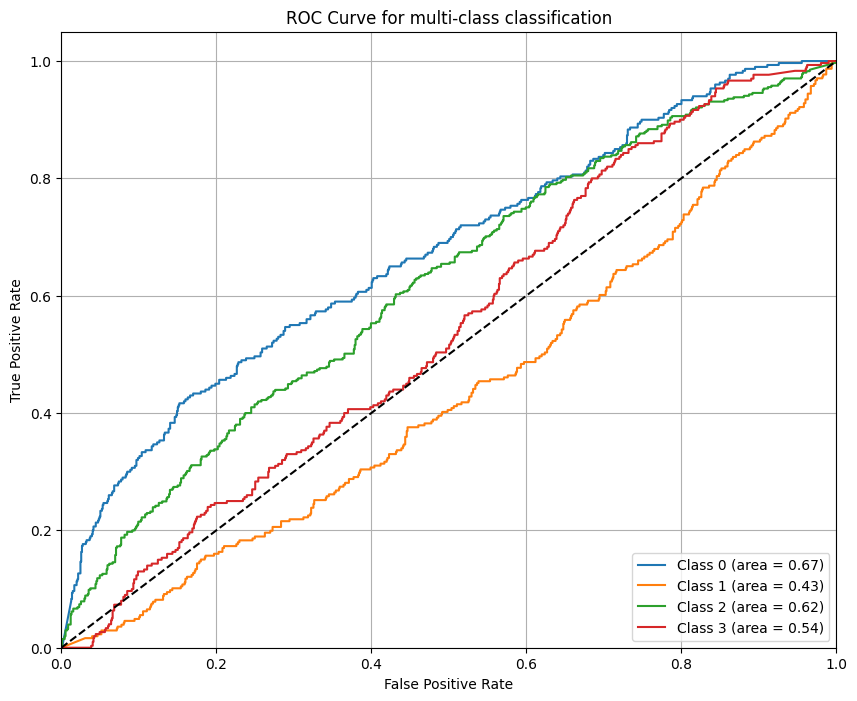

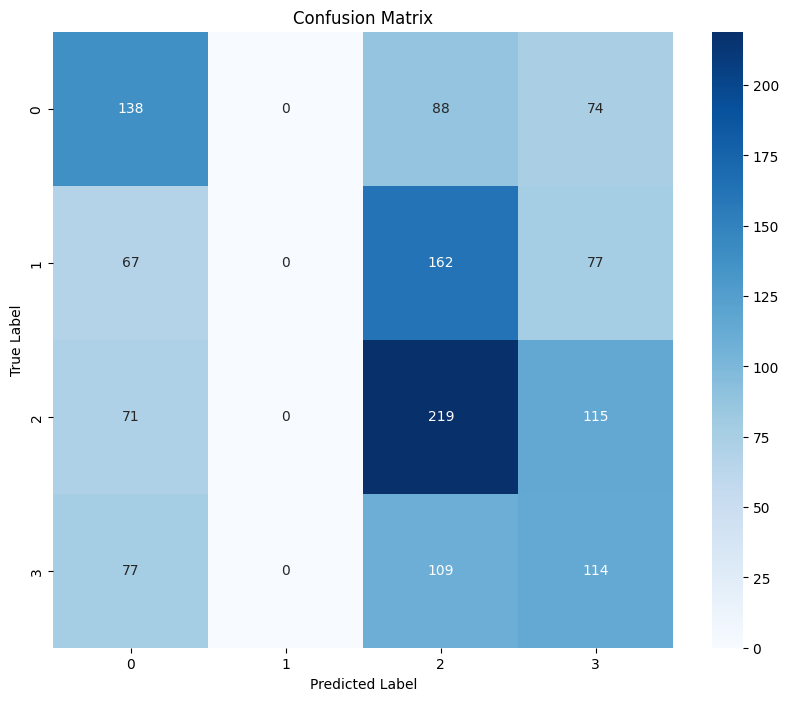

In [59]:
#Do evaluation
test_loss_transfer, test_acc_transfer = transfer_model.evaluate(X_test_transfer,y_test)
#Print the result
print(f"Test ACC: {test_acc_transfer}, Test LOSS: {test_loss_transfer}")

#Print ROC 

n_class2 = y_test.shape[1]
roc(y_test,y_test_pred_transfer,n_class2)

#confision matrix

cm(y_test,y_test_pred_transfer)

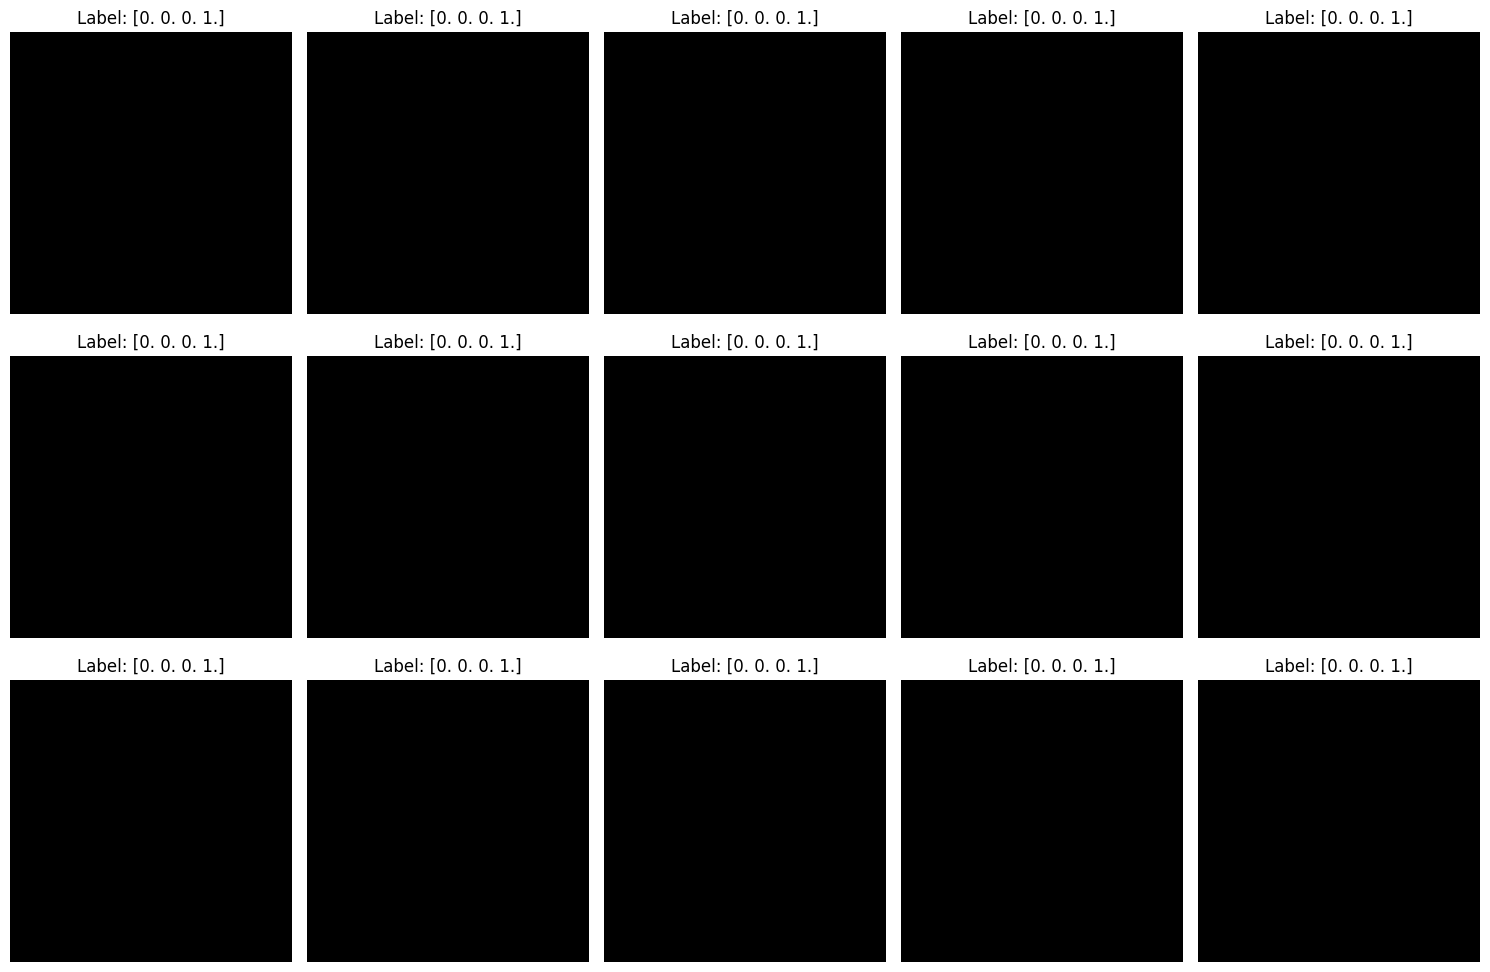

In [60]:

### Try to print the images to find potential issues:


# Visualise data
plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_train_transfer[i].squeeze(), cmap='gray')
    label_index = np.argmax(y_train[i])
    label_name = labels[label_index]
    plt.title(f"Label: {label_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()
